In [1]:
import scanpy as sc

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import muon
import cellrank
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)
                         
import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/

['default', 'despine']


In [2]:
mudata = muon.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/mudata_with_annotation_all.h5mu")

In [3]:
adata = mudata["rna"]
adata.obsm["X_umap"] = mudata.obsm["X_umap"]
adata.obs["cell_type_refined"] = mudata.obs["cell_type_refined"]

In [4]:
adata = adata[~adata.obs["cell_type"].isin(("Imm. Acinar", "Mat. Acinar", "Ductal", "Prlf. Ductal"))]

In [5]:
def adapt_time(x):
    if x["stage"]=="E14.5":
        return 14.5
    if x["stage"]=="E15.5":
        return 15.5
    if x["stage"]=="E16.5":
        return 16.5
    raise ValueError

adata.obs['time'] = adata.obs.apply(adapt_time, axis=1)

/tmp/ipykernel_436904/562334882.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['time'] = adata.obs.apply(adapt_time, axis=1)


In [6]:
color_dict = { 'Prlf. Ductal': '#f7b6d2', 'Ductal': '#d62728', 'Imm. Acinar': '#ffeb3b', 'Mat. Acinar': '#98df8a',
    'Alpha': '#1f77b4', 'Beta': '#ff7f0e', 'Delta': '#279e68', 'Eps. progenitors': '#aa40fc', 'Epsilon': '#8c564b',
       'Fev+': '#e377c2', 'Fev+ Alpha': '#b5bd61', 'Fev+ Beta': '#42f5ec', 'Fev+ Delta': '#aec7e8', 'Fev+ Delta,0': '#17becf', 'Fev+ Delta,1':'#98df8a',
      'Ngn3 high cycling': '#adf542',
        'Ngn3 high,0': '#ff9896', 'Ngn3 high': '#ff9896', 'Ngn3 high,1':'#f0b98d', 'Ngn3 low': '#c5b0d5'
}


In [7]:
adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")
adata.uns["cell_type_colors"] = [color_dict[ct] for ct in adata.obs["cell_type"].cat.categories]

In [8]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [9]:
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.diffmap(adata)

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


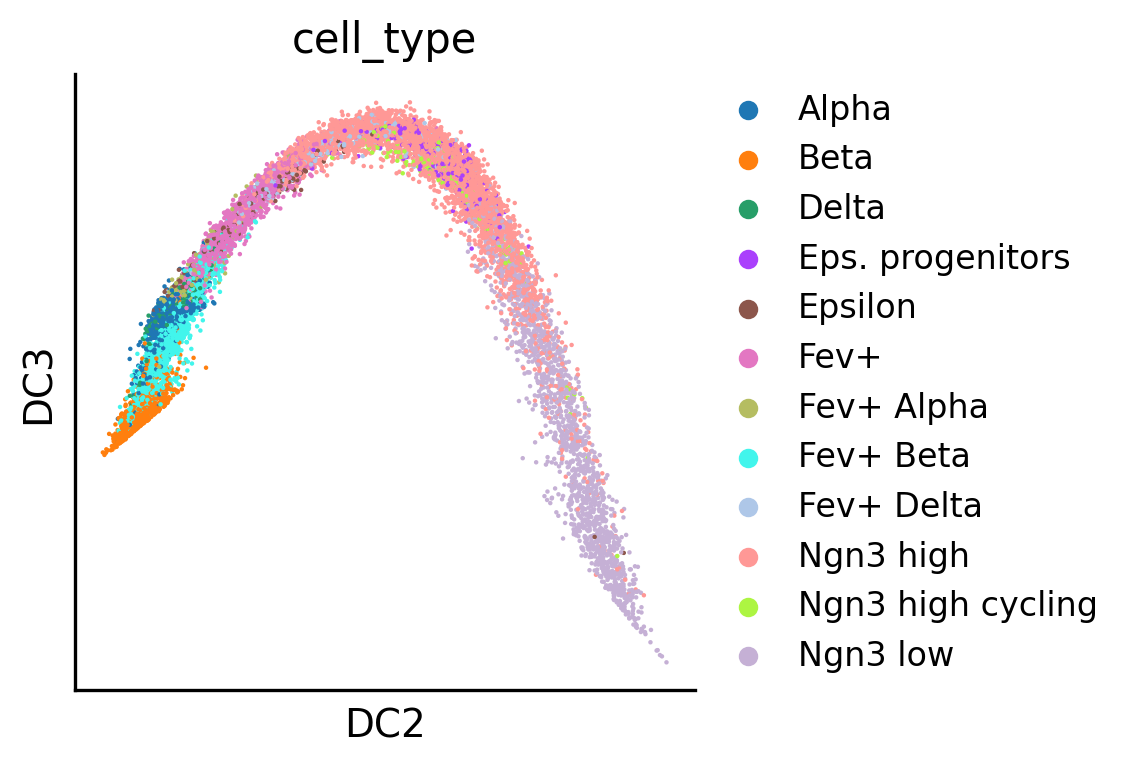

In [10]:
sc.pl.diffmap(adata, components=["2, 3"], color="cell_type")


In [11]:
adata.obsm["X_diffmap"][:,1].argmax()


8883

In [12]:
adata.uns["iroot"] = 8883

In [13]:
adata[8883].obs

,sample,name,stage,stage_num,int_id,seq_id_gex_id,seq_id_atac,reporter,experiment_batch,sequencing_batch,...,leiden_gex_graph,leiden_ATAC_graph,leiden_wnn_graph,cell_type,cell_type_refined,S_score,G2M_score,phase,proliferation,time
CGCAATCCATTGTGTG-3,NVF_E15-5_Rep2,E15.5 Rep. 2,E15.5,15.5,659,23L011297,23L011289,Neurog3-Venus-Fusion,Exp_2,Seq_3,...,12,11,6,Ngn3 low,Ngn3 low,-0.262444,-0.100622,G1,Non-Cycling,15.5


In [14]:
sc.pp.neighbors(adata, use_rep="X_pca")

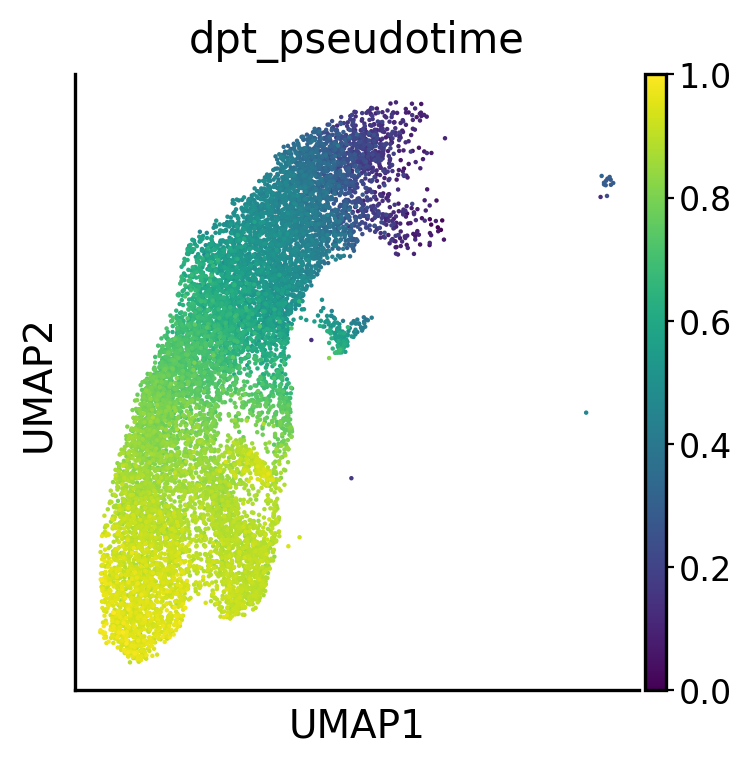

In [15]:
sc.tl.diffmap(adata)
sc.tl.dpt(adata)
sc.pl.embedding(
    adata,
    basis="umap",
    color=["dpt_pseudotime"],
)

In [16]:
pk = cellrank.kernels.PseudotimeKernel(adata, time_key="dpt_pseudotime")
pk.compute_transition_matrix(threshold_scheme='soft', b=12.0, nu=0.75, check_irreducibility=True, frac_to_keep=0.5)

100%|███████████████████████████████████████████████████████████████████████| 11645/11645 [00:03<00:00, 2914.91cell/s]


PseudotimeKernel[n=11645, dnorm=False, scheme='soft', b=12.0, nu=0.75]

In [17]:
g = cellrank.estimators.GPCCA(pk)

In [18]:
g.fit(cluster_key="cell_type", n_states=15)

GPCCA[kernel=PseudotimeKernel[n=11645], initial_states=None, terminal_states=None]

In [19]:
g.macrostates.cat.categories

Index(['Beta_1', 'Ngn3 high cycling', 'Epsilon', 'Delta', 'Eps. progenitors',
       'Beta_2', 'Ngn3 low_1', 'Beta_3', 'Ngn3 low_2', 'Alpha', 'Fev+ Alpha',
       'Fev+ Beta', 'Ngn3 high_1', 'Ngn3 high_2', 'Ngn3 high_3'],
      dtype='object')

In [20]:
g.set_terminal_states(states=["Alpha", "Beta_1", "Epsilon", "Delta"])

GPCCA[kernel=PseudotimeKernel[n=11645], initial_states=None, terminal_states=['Alpha', 'Beta_1', 'Delta', 'Epsilon']]

In [21]:
g.compute_fate_probabilities()

Defaulting to `'gmres'` solver.


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87/s]


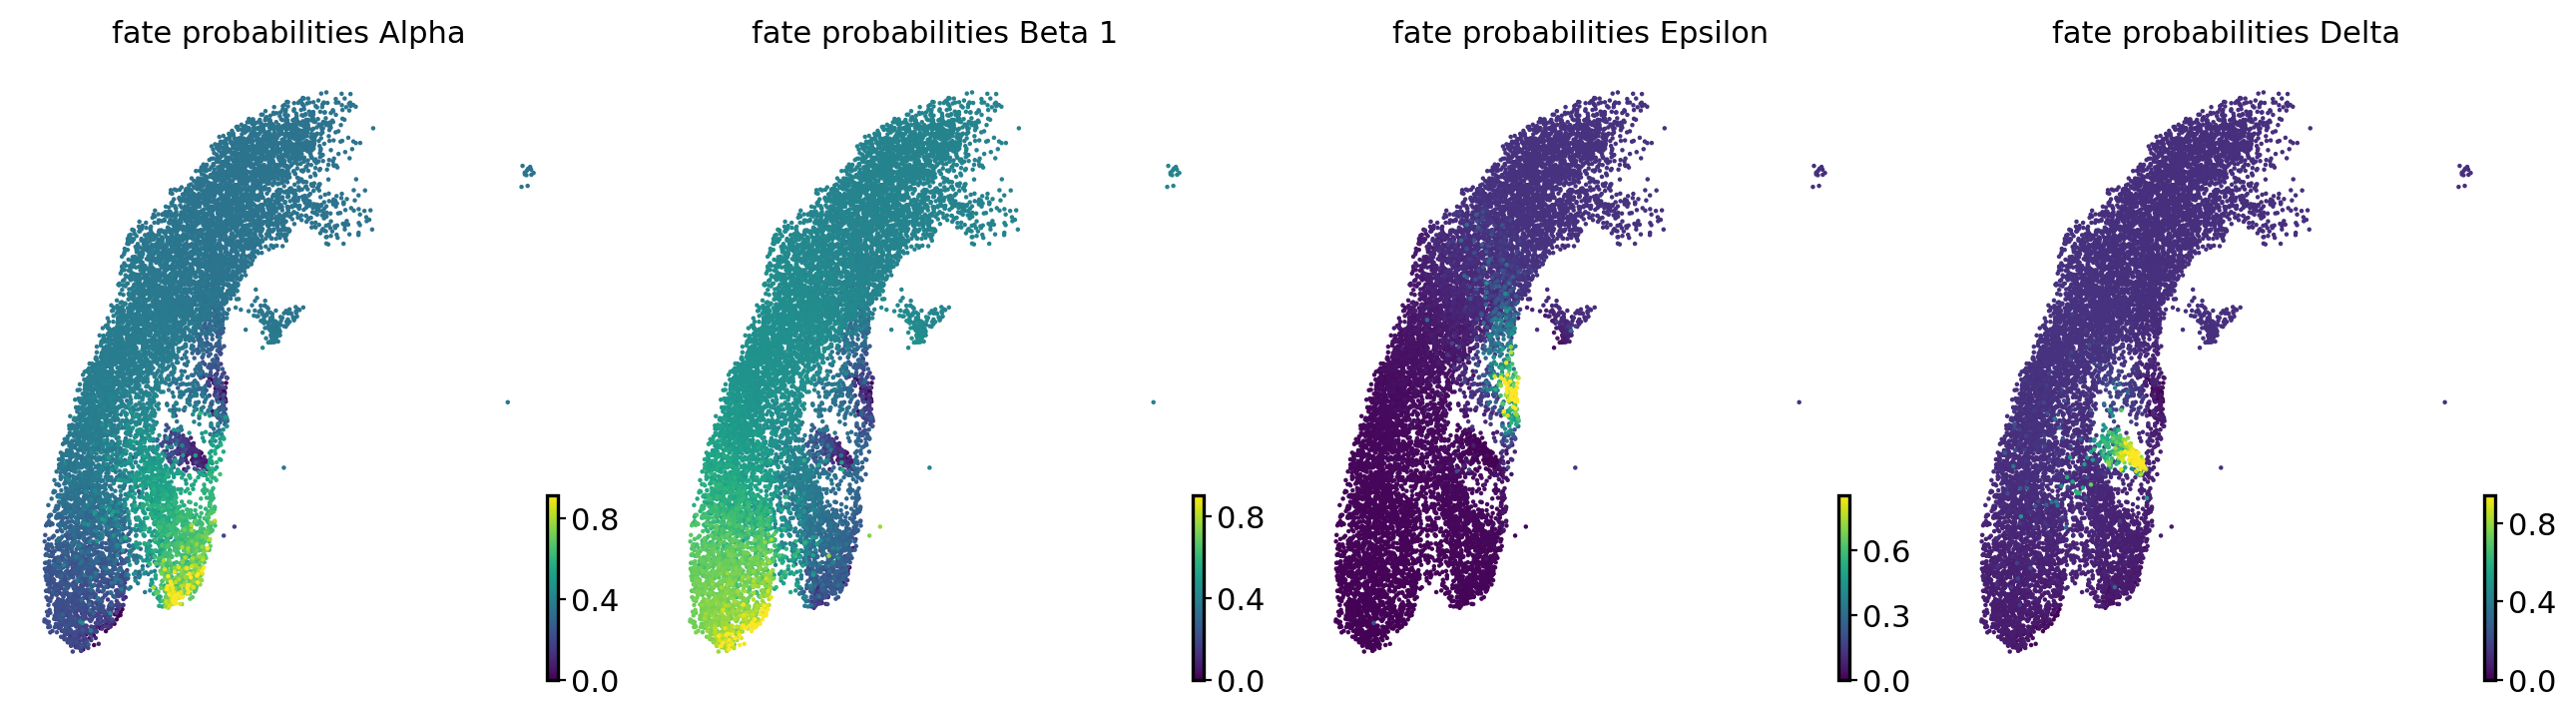

In [22]:
g.plot_fate_probabilities(same_plot=False)

In [23]:
%matplotlib inline

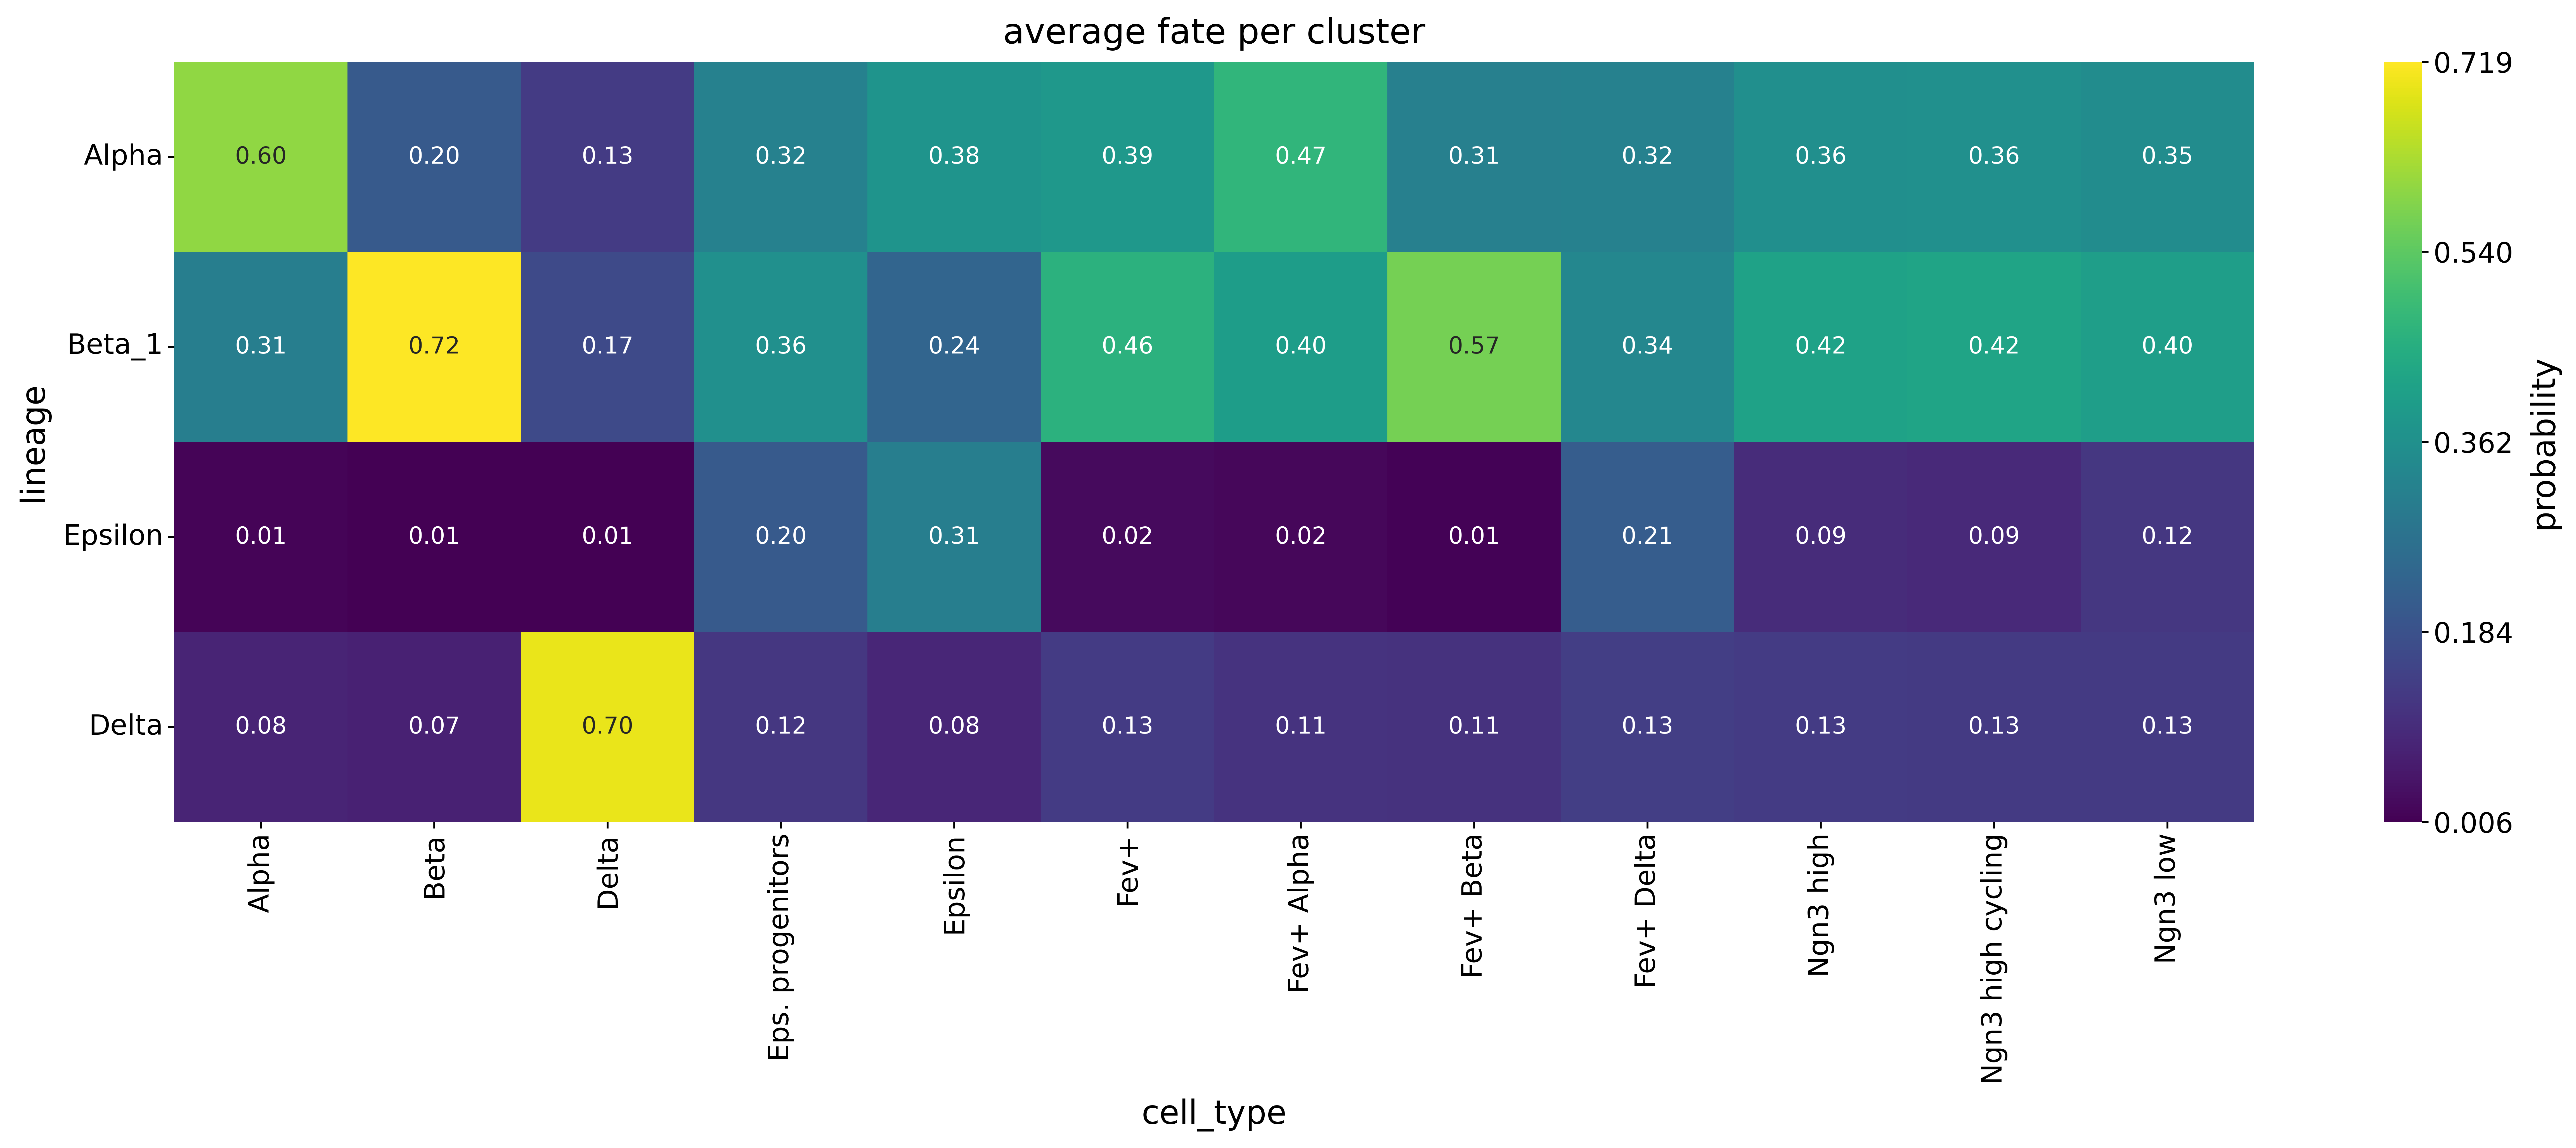

In [24]:
cellrank.pl.aggregate_fate_probabilities(
        adata=adata,
        mode='heatmap',
        lineages=["Alpha", "Beta_1", "Epsilon", "Delta"],
        cluster_key="cell_type",
        clusters=None,
        figsize=(20, 6),
        dpi=300,
    )

In [32]:
adata.obsm["lineages_fwd"].colors = color_dict["Alpha"], color_dict["Beta"], color_dict["Epsilon"], color_dict["Delta"]

In [33]:
model = cellrank.models.GAM(adata, distribution='gaussian', n_knots=12, link='identity')

100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/gene]


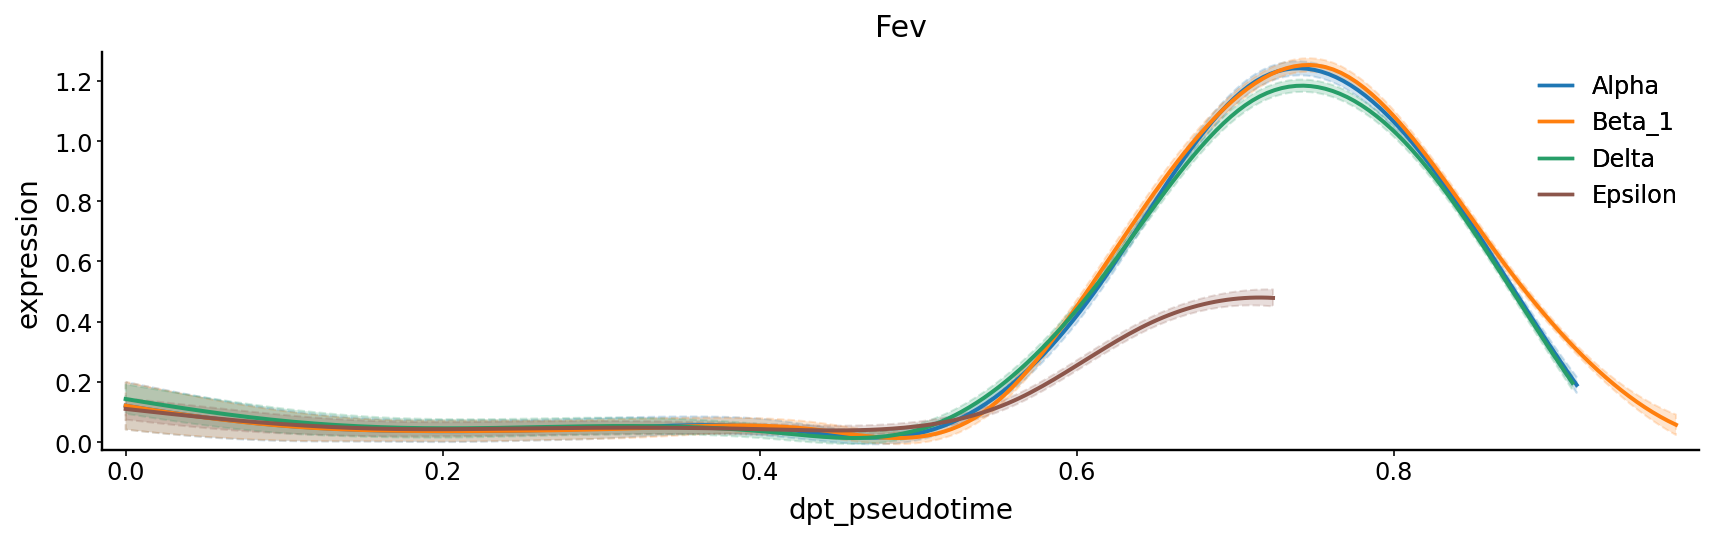

In [34]:
cellrank.pl.gene_trends(
    adata,
    model=model,
    #data_key="X",
    genes=["Fev"],
    same_plot=True,
    ncols=2,
    time_key="dpt_pseudotime",
    hide_cells=True,
    figsize=(12, 4),
    weight_threshold=(1e-3, 1e-3),
)

100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.74gene/s]


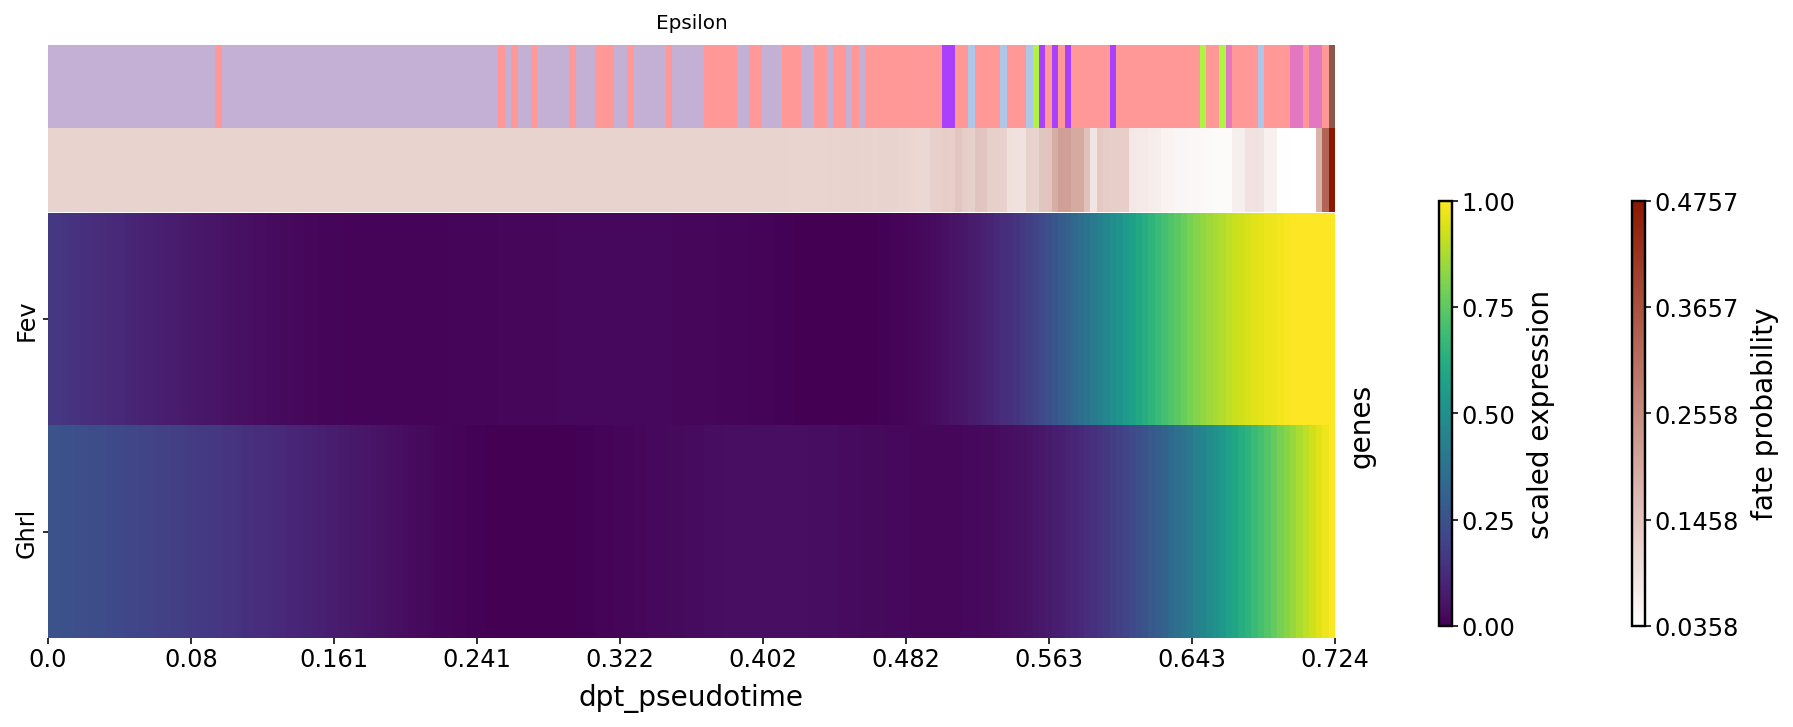

In [35]:
cellrank.pl.heatmap(
    adata,
    model=model,  # use the model from before
    lineages="Epsilon",
    cluster_key="cell_type",
    show_fate_probabilities=True,
    #data_key="magic_imputed_data",
    genes=["Fev", "Ghrl"],
    time_key="dpt_pseudotime",
    figsize=(12, 4),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)

100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.43gene/s]


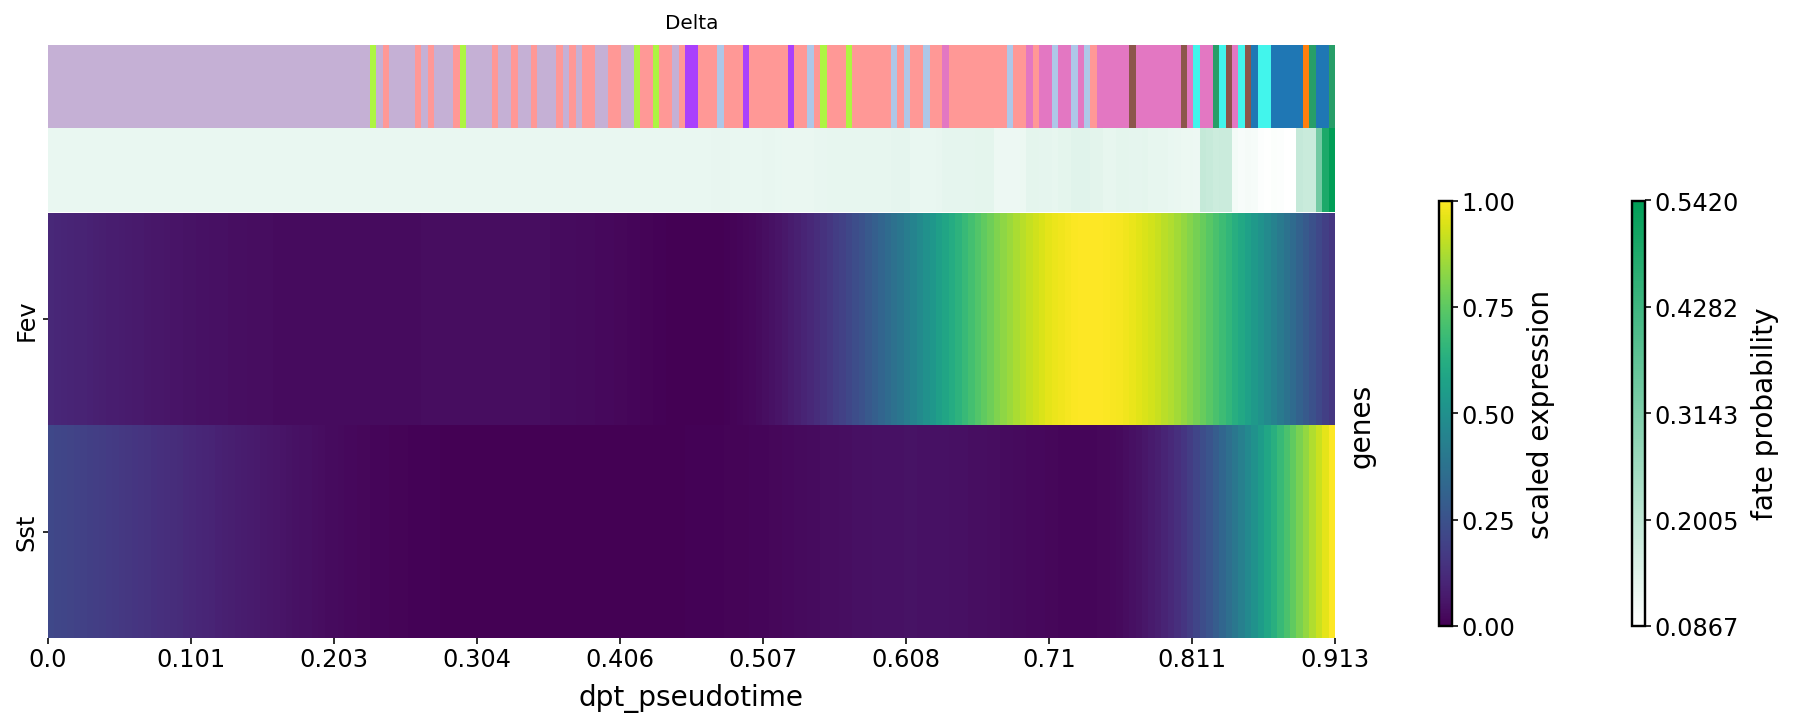

In [36]:
cellrank.pl.heatmap(
    adata,
    model=model,  # use the model from before
    lineages="Delta",
    cluster_key="cell_type",
    show_fate_probabilities=True,
    #data_key="magic_imputed_data",
    genes=["Fev", "Sst"],
    time_key="dpt_pseudotime",
    figsize=(12, 4),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)

100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.45gene/s]


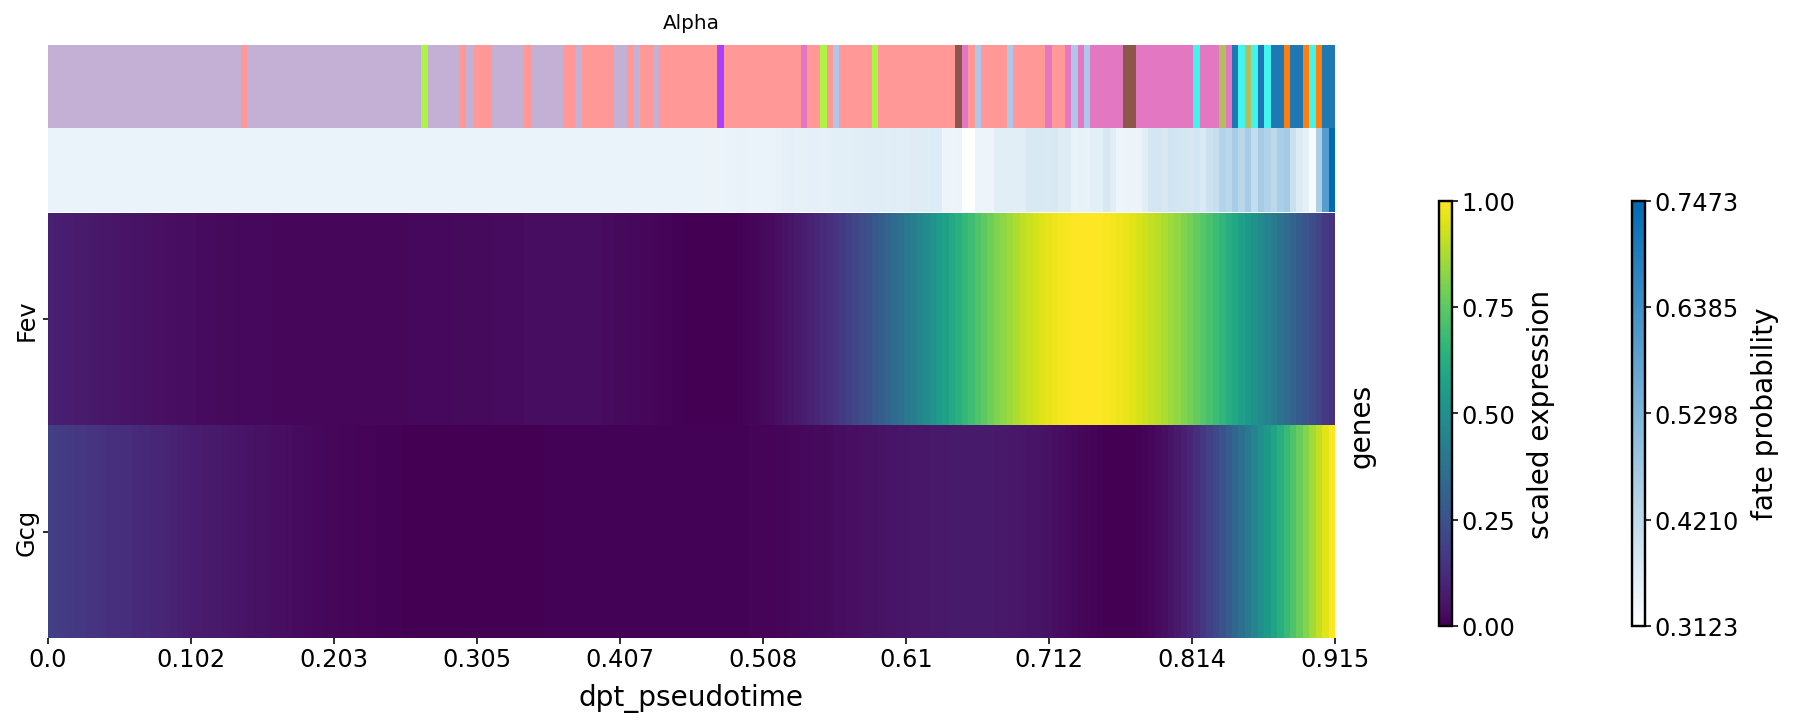

In [39]:
cellrank.pl.heatmap(
    adata,
    model=model,  # use the model from before
    lineages="Alpha",
    cluster_key="cell_type",
    show_fate_probabilities=True,
    #data_key="magic_imputed_data",
    genes=["Fev", "Gcg"],
    time_key="dpt_pseudotime",
    figsize=(12, 4),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)

100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.30gene/s]


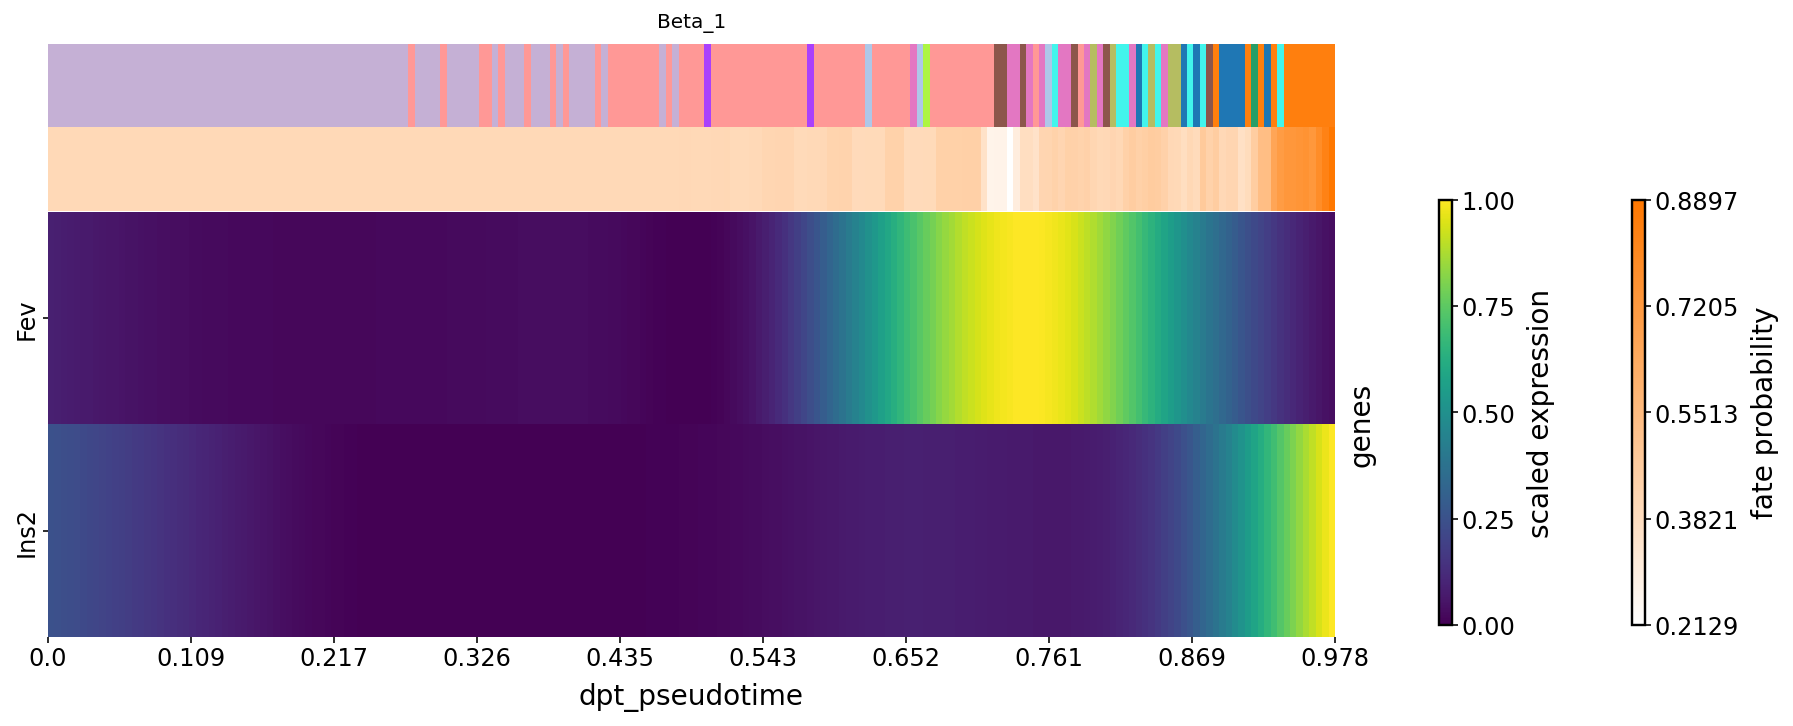

In [38]:
cellrank.pl.heatmap(
    adata,
    model=model,  # use the model from before
    lineages="Beta_1",
    cluster_key="cell_type",
    show_fate_probabilities=True,
    #data_key="magic_imputed_data",
    genes=["Fev", "Ins2"],
    time_key="dpt_pseudotime",
    figsize=(12, 4),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)